In [162]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, Activation, MaxPool2D

import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K

import os
from shutil import copyfile

In [163]:
## move files to train and test folders

## make train and test directories
with open('food41/meta/classes.txt', 'r') as fp:
    line = fp.readline()
    while line:
        line = line.strip()
        try:
            os.makedirs('train/'+line)
        except FileExistsError:
            # directory already exists
            pass
        try:
            os.makedirs('test/'+line)
        except FileExistsError:
            # directory already exists
            pass
        line = fp.readline()


with open('food41/meta/train.txt', 'r') as fp:
    line = fp.readline()
    while line:
        line = line.strip()
        src = 'food41/images/' + line + '.jpg'
        dst = 'train/' + line + '.jpg'
        copyfile(src, dst)
#         os.rename(src, dst)
        line = fp.readline()
    

with open('food41/meta/test.txt', 'r') as fp:
    line = fp.readline()
    while line:
        line = line.strip()
        src = 'food41/images/' + line + '.jpg'
        dst = 'test/' + line + '.jpg'
        copyfile(src, dst)
#         os.rename(src, dst)
        line = fp.readline()

In [164]:
nrow = 64
ncol = 64

In [165]:
train_data_dir = './train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

test_data_dir = './test'
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [166]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

(64, 64, 3)
3.0


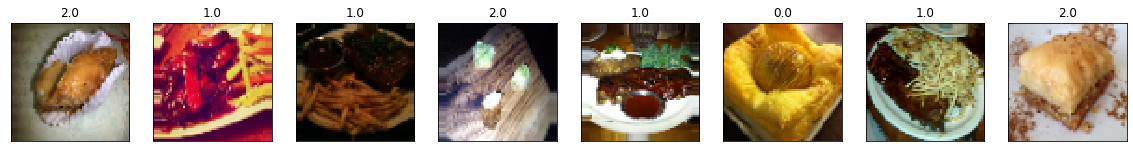

In [167]:
X,y = train_generator.next()
plt.figure(figsize=(20,20))
nplot = 8
for i in range(nplot):
    plt.subplot(1,nplot,i+1)
    disp_image(X[i])
    plt.title(y[i])
print(X.shape[1:])
print(np.max(y)+1)

In [168]:
# build model
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(np.max(y)+1))
model.add(Activation('softmax'))
model.summary()



Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_118 (Activation)  (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_119 (Activation)  (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 31, 31, 64)      

In [ ]:
# train model
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size
nepochs = 5  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/5
32/70 [============>.................] - ETA: 18s - loss: 1.2305 - accuracy: 0.3593